In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [30]:
raw_data = pd.read_csv('/content/drive/MyDrive/Google Colab Notebooks/Mini Sem 8/dataset/large sample/IBM_2years_15Min (1).csv')

In [31]:
print(raw_data.shape)
raw_data.head()

(21541, 7)


,Unnamed: 0,time,open,high,low,close,volume
0,0,2022-03-25 19:30:00,131.300,131.30,131.300,131.30,1000
1,1,2022-03-25 18:00:00,131.300,131.30,131.300,131.30,100
2,2,2022-03-25 17:00:00,131.340,131.35,131.340,131.35,1427
3,3,2022-03-25 16:45:00,131.326,131.35,131.326,131.35,1326
4,4,2022-03-25 16:15:00,131.350,131.40,131.350,131.40,56109


In [32]:
open_ds = raw_data.loc[:, ['time', 'open']]
high_ds = raw_data.loc[:, ['time', 'high']]
low_ds = raw_data.loc[:, ['time', 'low']]
close_ds = raw_data.loc[:, ['time', 'close']]
volume_ds = raw_data.loc[:, ['time', 'volume']]

In [33]:
# reversing the dataframe 
close_ds_rev = close_ds.loc[::-1, :]
close_ds_rev = close_ds_rev.reset_index(drop=True)
close_ds_rev.head()

,time,close
0,2020-04-06 07:15:00,94.703037
1,2020-04-06 07:30:00,95.557695
2,2020-04-06 07:45:00,95.013822
3,2020-04-06 08:00:00,95.177847
4,2020-04-06 08:15:00,94.746202


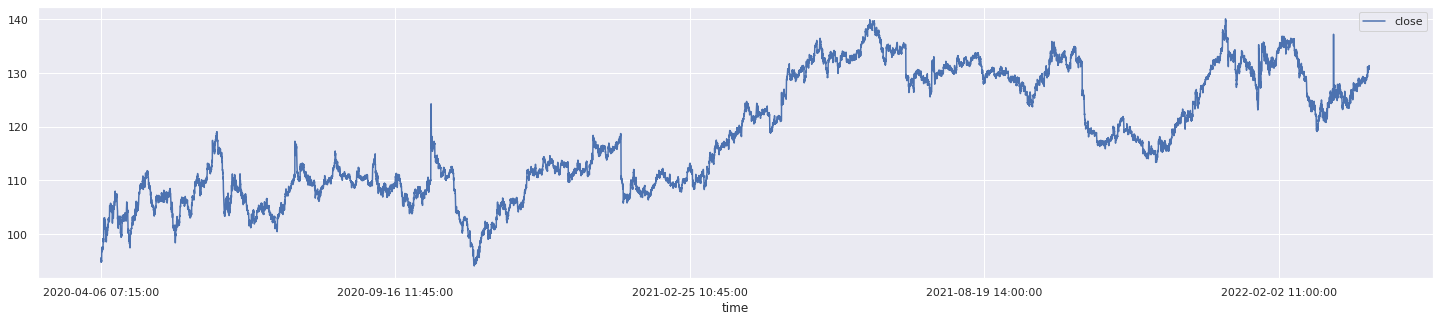

In [34]:
close_ds_rev.plot(x='time', y='close', figsize=(25, 5))

In [35]:
# converting time serires into a supervised learning problem
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [36]:
# n_in ---> number of previous data points (lag observations) to consider as input
# n_out --> number of datapoints to predict
# dataset ----> dataframe with (n_in + n_out + 1 [for current timestamp]) numbers of columns used for supervised training of the model 

n_in = 50
n_out = 1
dataset = series_to_supervised(close_ds_rev.drop('time', axis=1), n_in, n_out)
print(dataset.shape)
dataset.head()

(21490, 52)


,close(t-50),close(t-49),close(t-48),close(t-47),close(t-46),close(t-45),close(t-44),close(t-43),close(t-42),close(t-41),...,close(t-8),close(t-7),close(t-6),close(t-5),close(t-4),close(t-3),close(t-2),close(t-1),close(t),close(t+1)
50,94.703037,95.557695,95.013822,95.177847,94.746202,95.022455,94.962024,94.962024,94.962024,94.875695,...,98.458353,98.915898,99.123088,102.904303,102.041012,101.989214,102.731645,102.291366,102.593518,101.876986
51,95.557695,95.013822,95.177847,94.746202,95.022455,94.962024,94.962024,94.962024,94.875695,96.084303,...,98.915898,99.123088,102.904303,102.041012,101.989214,102.731645,102.291366,102.593518,101.876986,102.299999
52,95.013822,95.177847,94.746202,95.022455,94.962024,94.962024,94.962024,94.875695,96.084303,97.500100,...,99.123088,102.904303,102.041012,101.989214,102.731645,102.291366,102.593518,101.876986,102.299999,101.980581
53,95.177847,94.746202,95.022455,94.962024,94.962024,94.962024,94.875695,96.084303,97.500100,97.317255,...,102.904303,102.041012,101.989214,102.731645,102.291366,102.593518,101.876986,102.299999,101.980581,102.774809
54,94.746202,95.022455,94.962024,94.962024,94.962024,94.875695,96.084303,97.500100,97.317255,97.059822,...,102.041012,101.989214,102.731645,102.291366,102.593518,101.876986,102.299999,101.980581,102.774809,102.222303


In [37]:
# train test split

from sklearn.model_selection import train_test_split
target = dataset.loc[:, ['close(t+1)']]
features = dataset.drop('close(t+1)', axis=1)
print(target.shape)
print(features.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(21490, 1)
(21490, 51)
(15043, 51)
(15043, 1)
(6447, 51)
(6447, 1)


In [38]:
# Model training

from tensorflow import keras 
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

# Multilayer perceptron 

model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.0003))
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               5200      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [39]:
mlp_history = model_mlp.fit(X_train.values, y_train.values, validation_data=(X_test.values, y_test.values), epochs=40, verbose=2)

Epoch 1/40
471/471 - 2s - loss: 29.4632 - val_loss: 1.2994 - 2s/epoch - 4ms/step
Epoch 2/40
471/471 - 1s - loss: 1.5200 - val_loss: 1.2322 - 880ms/epoch - 2ms/step
Epoch 3/40
471/471 - 1s - loss: 1.4408 - val_loss: 1.1305 - 865ms/epoch - 2ms/step
Epoch 4/40
471/471 - 1s - loss: 1.3680 - val_loss: 1.3478 - 969ms/epoch - 2ms/step
Epoch 5/40
471/471 - 1s - loss: 1.2718 - val_loss: 1.3130 - 966ms/epoch - 2ms/step
Epoch 6/40
471/471 - 1s - loss: 1.1573 - val_loss: 0.8976 - 958ms/epoch - 2ms/step
Epoch 7/40
471/471 - 1s - loss: 1.0115 - val_loss: 4.5964 - 854ms/epoch - 2ms/step
Epoch 8/40
471/471 - 1s - loss: 1.0389 - val_loss: 1.7376 - 864ms/epoch - 2ms/step
Epoch 9/40
471/471 - 1s - loss: 0.9653 - val_loss: 1.0131 - 847ms/epoch - 2ms/step
Epoch 10/40
471/471 - 1s - loss: 0.9249 - val_loss: 0.5507 - 954ms/epoch - 2ms/step
Epoch 11/40
471/471 - 1s - loss: 0.8836 - val_loss: 1.7976 - 953ms/epoch - 2ms/step
Epoch 12/40
471/471 - 1s - loss: 0.7612 - val_loss: 1.0803 - 959ms/epoch - 2ms/step
Epo

Text(0, 0.5, 'MSE')

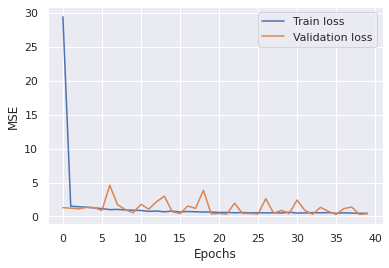

In [40]:
# plots 
fig = plt.figure()
plt.plot(mlp_history.history['loss'], label='Train loss')
plt.plot(mlp_history.history['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MSE')

In [41]:
# RMSE calculation
from sklearn.metrics import mean_squared_error
mlp_train_pred = model_mlp.predict(X_train)
mlp_test_pred = model_mlp.predict(X_test)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_test, mlp_test_pred)))

Train rmse: 0.5698243489731235
Validation rmse: 0.6310946069588709


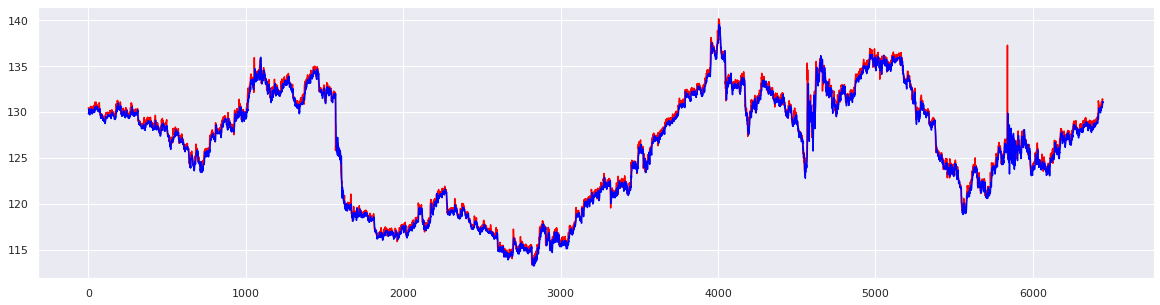

In [46]:

plt.figure(figsize=(20, 5))
plt.plot(y_test.reset_index(drop=True), color='red')
plt.plot(mlp_test_pred, color='blue')